In [1]:
import eland as ed
import numpy as np
import os

from elasticsearch import Elasticsearch
from dotenv import load_dotenv
from app.utils.backtesting_utils import get_ema

os.chdir("..")
load_dotenv()

True

In [2]:
es_url = os.environ.get('ELASTICSEARCH_URL')
es_api_key = os.environ.get('ELASTICSEARCH_API_KEY')
es = Elasticsearch(hosts=[f"{es_url}"], api_key=es_api_key)

In [3]:
%%capture
ticker="ASML"
df_eod = ed.DataFrame(es, es_index_pattern="quant-agents_stocks-eod_*")
df_eod = df_eod[(df_eod.key_ticker == ticker)]
df_ema = ed.eland_to_pandas(df_eod).sort_values(by='date_reference', ascending=True).tail(100).set_index('date_reference')
df_ema, df_crossovers = get_ema(df_ema)

In [4]:
df_ema.tail()

,key_ticker,val_close,val_high,val_low,val_open,val_volume,ema_short,ema_long,position,returns,strategy
date_reference,,,,,,,,,,,
2025-10-20,ASML,1042.150,1052.170,1031.49,1031.750,1271713,1006.538607,978.422506,1,0.012436,0.012436
2025-10-21,ASML,1025.020,1037.475,1024.15,1036.305,1072158,1009.898861,982.860363,1,-0.016574,-0.016574
2025-10-22,ASML,1011.565,1033.180,997.67,1026.450,1328598,1010.201795,985.594138,1,-0.013213,-0.013213
2025-10-23,ASML,1036.410,1040.500,1004.50,1004.520,1318221,1014.966923,990.433744,1,0.024264,0.024264
2025-10-24,ASML,1033.100,1043.400,1032.18,1037.930,1032742,1018.263846,994.497197,1,-0.003199,-0.003199


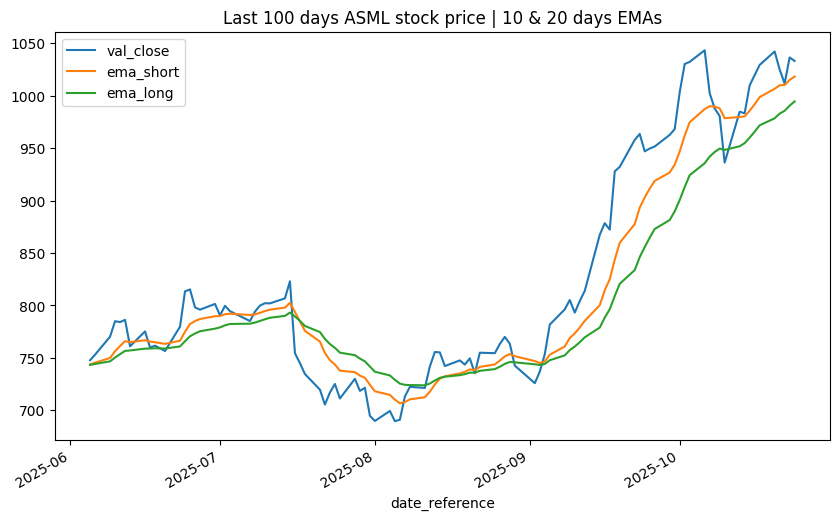

In [5]:
df_ema[["val_close", "ema_short", "ema_long"]].plot(title=f"Last 100 days {ticker} stock price | 10 & 20 days EMAs", figsize=(10, 6));

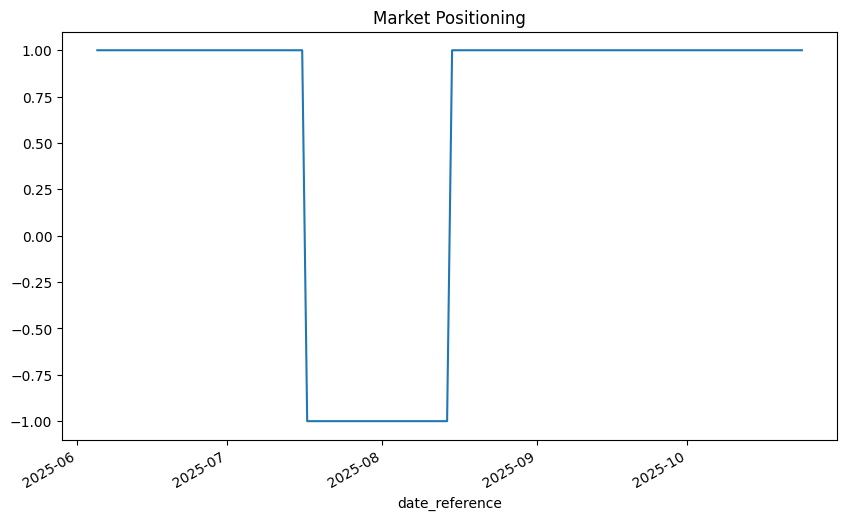

In [6]:
df_ema['position'].plot(
    ylim=[-1.1, 1.1],
    title='Market Positioning',
    figsize=(10, 6)
);

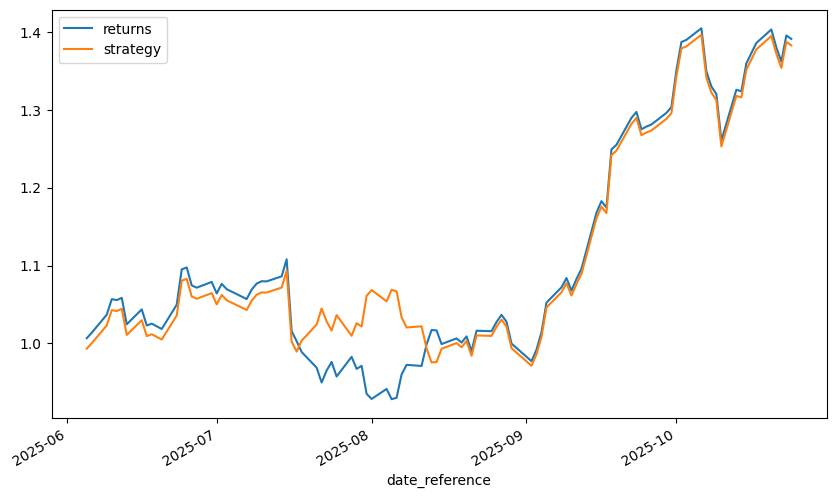

In [7]:
df_ema[['returns', 'strategy']].dropna().cumsum().apply(np.exp).plot(figsize=(10, 6));

In [8]:
df_crossovers[['val_close', 'ema_short', 'ema_long', 'position']]

,val_close,ema_short,ema_long,position
date_reference,,,,
2025-07-17,744.91,784.865164,785.221505,-1
2025-08-15,742.16,732.375324,732.008040,1
